### Load Data from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
import json
token = {"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!mkdir ~/.kaggle
!echo '{"username":"cameronwebster","key":"5e70b65a76b1214dee43d83e7143f395"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json && pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!rm -r cassava-leaf-disease-classification
!mkdir cassava-leaf-disease-classification
!kaggle competitions download -c cassava-leaf-disease-classification -p cassava-leaf-disease-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 5.75G/5.76G [01:38<00:00, 83.0MB/s]
100% 5.76G/5.76G [01:38<00:00, 62.5MB/s]


In [5]:
from zipfile import ZipFile
file_name = '/content/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip'

with ZipFile(file_name, 'r') as zip:

  print("Extracting new files")
  zip.extractall()
  print("done!")

Extracting new files
done!


### Import Statements

In [6]:
import tensorflow as tf
import os
from functools import partial
!pip install -q wandb
import wandb
from matplotlib import pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, InputLayer, 
    Conv2D, MaxPooling2D, ZeroPadding2D, LeakyReLU, Dropout, BatchNormalization
    )

from keras.layers.experimental.preprocessing import (
    RandomFlip, RandomRotation, RandomTranslation, RandomZoom, RandomContrast
    )

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    )

### Parameters, Logging Initiation

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_SEED = 42
BATCH_SIZE = 64 
IMAGE_SIZE = [224, 224]
EPOCHS = 100
LR = 0.001
CLASSES = 5
TRAIN_SPLIT = 0.8

# Early Stopping
MIN_DELTA_ES = 0.001
PATIENCE_ES = 15

# Reduce LR on Plateau
FACTOR_RLR = 0.5
PATIENCE_RLR = 3
MIN_DELTA_RLR = 0.0001
MIN_LR = 0.00000001


RECORD_PATH = tf.io.gfile.glob("train_tfrecords/*.tfrec")
# SAVE_PATH = '/content/drive/Shareddrives/2040_Midterm_Project/Classy_Classifiers/model_checkpoints/vgg_models/'
SAVE_PATH = '/content/drive/MyDrive/DATA_2040/'
SAVE_NAME = "March19-vgg-{epoch:02d}-{val_loss:.2f}.hdf5" 

wandb.init(project="VGG16")

wandb: Currently logged in as: camweb (use `wandb login --relogin` to force relogin)


### Data Extraction Pipeline

In [8]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE[0],IMAGE_SIZE[1]])
    image = image / 255.0 # recale by 255 for inputs between 0 and 1
    return image

In [9]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        label = tf.one_hot(label, 5)
        return image, label
    return image

In [10]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [11]:
data_augmentation = Sequential([
    # RandomCrop(height=100, width=100),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(15),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
    # RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
    RandomContrast(factor=0.2)
])

### Shuffling, Splitting, Batching, Augmenting train set, Caching val set, Prefetching

splitting from: https://stackoverflow.com/questions/60704335/how-to-create-train-test-validation-split-of-tf-data-dataset-in-tf-2-1-0

shuffling, batchingm caching, prefetching from https://www.kaggle.com/tt195361/splitting-tensorflow-dataset-for-validation

In [12]:
def get_datasets(filenames, labeled=True, train_split=TRAIN_SPLIT):

    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048, seed=SHUFFLE_SEED)

    # First, split our train dataset into train and validation

    # Size of dataset
    n = sum(1 for _ in dataset)
    n_train = int(n * train_split)
    n_valid = n - n_train

    train_dataset = dataset.take(n_train)
    val_dataset = dataset.skip(n_train).take(n_valid)

    train_dataset = train_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.batch(BATCH_SIZE)

    # Augment the training set
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y), 
                  num_parallel_calls=AUTOTUNE)
    
    # From Docs: "The first time the dataset is iterated over, its elements 
    # will be cached either in the specified file or in memory. Subsequent 
    # iterations will use the cached data."
    val_dataset = val_dataset.cache()
    
    # prefetch "allows later elements to be prepared while the current 
    # element is being processed"
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset

In [13]:
train_dataset, val_dataset = get_datasets(RECORD_PATH)

### (Optional) Inspect Records

In [14]:
# image_batch, label_batch = next(iter(dataset_original))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10, 10))
#     for n in range(25):
#         ax = plt.subplot(5, 5, n + 1)
#         plt.imshow(image_batch[n] / 255.0)
#         plt.title(f"{label_batch[n]}")
#         plt.axis("off")

# show_batch(image_batch.numpy(), label_batch.numpy())

# for raw_record in dataset_original.take(1):
    # example = tf.train.Example()
    # example.ParseFromString(raw_record)
    # print(example)

### Sequential Model

In [15]:
# Re-loads the MobileNet model without the top or FC layers
# tf.keras.backend.clear_session()

vgg16 = VGG16(weights = 'imagenet', 
              classifier_activation=None, 
              include_top = False, 
              input_shape = (IMAGE_SIZE[0],IMAGE_SIZE[1],3), 
              classes=CLASSES)

for layer in vgg16.layers:
    layer.trainable = False
    
model = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),              

    vgg16,
    GlobalAveragePooling2D(),

    Dense(1024, kernel_regularizer='l2'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Dense(512, kernel_regularizer='l2'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Dense(128, kernel_regularizer='l2'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),
    
    # naming the final layer before the softmax so we can use the pre-softmax 
    # output as our input to a kNN classifier
    Dense(32, kernel_regularizer='l2', name='embedding'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Dense(CLASSES,activation='softmax')
])

### Class Weighting
From kaggle private test set inspection

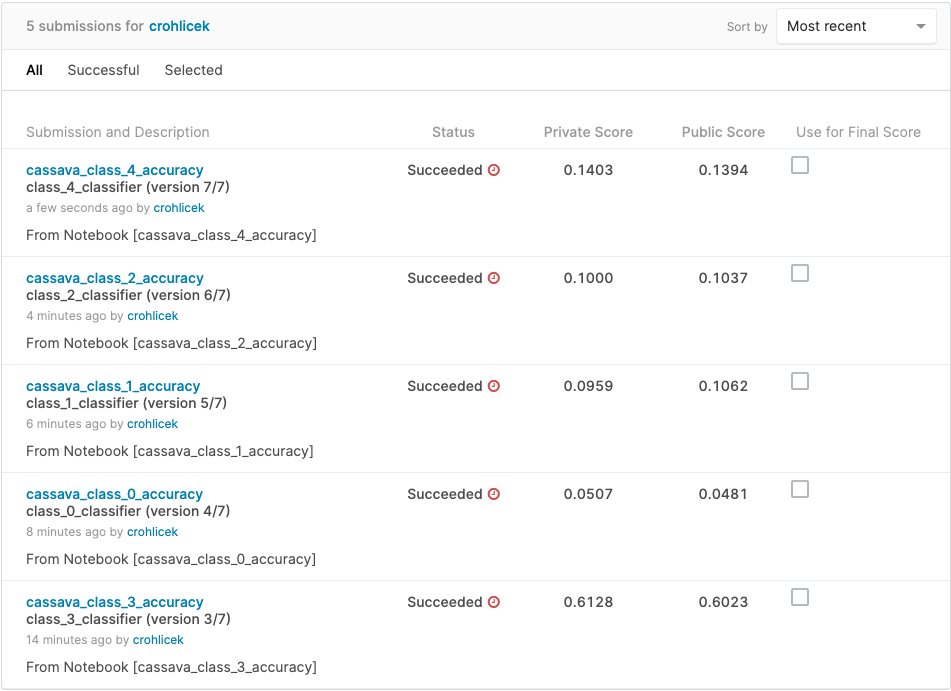

In [16]:
class_weights = {0: 1/0.0507,
                 1: 1/0.0959,
                 2: 1/0.1000,
                 3: 1/0.6128,
                 4: 1/0.1403}

### Callbacks, Compilation, Build, Summary

In [17]:
checkpoint = ModelCheckpoint(SAVE_PATH+SAVE_NAME,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             save_weights_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = MIN_DELTA_ES, 
                          patience = PATIENCE_ES,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = FACTOR_RLR,
                              patience = PATIENCE_RLR,
                              verbose = 1,
                              min_delta = MIN_DELTA_RLR,
                              min_lr = MIN_LR)

callbacks = [checkpoint,earlystop,reduce_lr, wandb.keras.WandbCallback()]

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=LR),
              metrics = ['accuracy'])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

### Model Fitting

In [18]:
history = model.fit(
    train_dataset,
    # class_weight = class_weights,
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = callbacks,
    verbose = 1#,
    #batch_size=BATCH_SIZE#,
    #steps_per_epoch = STEPS_PER_EPOCH,
    #validation_steps = VALIDATION_STEPS
)

Epoch 1/100
268/268 [==============================] - 182s 589ms/step - loss: 11.2749 - accuracy: 0.4611 - val_loss: 2.5702 - val_accuracy: 0.6229

Epoch 00001: val_loss improved from inf to 2.57022, saving model to /content/drive/MyDrive/DATA_2040/March19-vgg-01-2.57.hdf5
Epoch 2/100
268/268 [==============================] - 123s 442ms/step - loss: 2.1530 - accuracy: 0.6330 - val_loss: 1.4223 - val_accuracy: 0.6460

Epoch 00002: val_loss improved from 2.57022 to 1.42231, saving model to /content/drive/MyDrive/DATA_2040/March19-vgg-02-1.42.hdf5
Epoch 3/100
268/268 [==============================] - 122s 440ms/step - loss: 1.4078 - accuracy: 0.6413 - val_loss: 1.2125 - val_accuracy: 0.6682

Epoch 00003: val_loss improved from 1.42231 to 1.21247, saving model to /content/drive/MyDrive/DATA_2040/March19-vgg-03-1.21.hdf5
Epoch 4/100
268/268 [==============================] - 125s 449ms/step - loss: 1.2689 - accuracy: 0.6498 - val_loss: 1.2213 - val_accuracy: 0.6526

Epoch 00004: val_loss

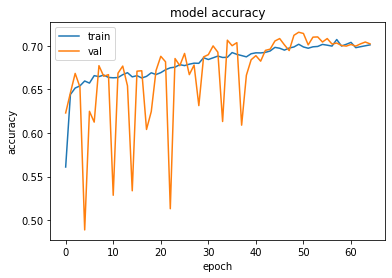

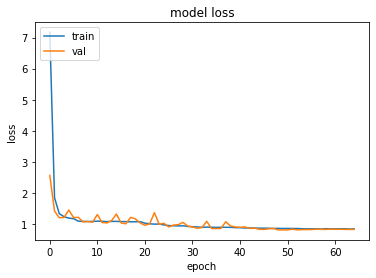

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# model.save(save_path+"vgg_03-15-21.h5", save_format='h5')
wandb.finish()

epoch,64
loss,0.85325
accuracy,0.70094
val_loss,0.8388
val_accuracy,0.7021
lr,0.0
_runtime,8230
_timestamp,1616191737
_step,64
best_val_loss,0.82109
best_epoch,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▃▃▄▃▂▂▂▂▃▂▂▂▂▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅▆▆▁▅▆▆▇▆▂▇▅▇▇▂▇▆▇▇█▇██▅▇▇▇██▇██████████
lr,████▄▄▄▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
